# DNN Model

In [114]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [115]:
# data loading from .npz generated from tcr_data_process.ipynb
# loading train data
npz = np.load('data_train.npz')
train_inputs = npz['input'].astype(np.float64)
train_targets = npz['targets'].astype(np.float64)
# loading validation data
npz = np.load('data_validation.npz')
validation_inputs, validation_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

npz = np.load('data_test.npz')
test_inputs, test_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

# ANN Model

Outline, Optimizer, Loss function, Early stopping and Training rate

In [116]:
# NN model prep
input_size = 3
output_size = 1
hidden_layer_1_size = 10
hidden_layer_2_size = 10
hidden_layer_3_size = 10

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size),
    tf.keras.layers.Dense(hidden_layer_1_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_2_size, activation='tanh'),
    tf.keras.layers.Dense(hidden_layer_3_size, activation='sigmoid'),
    tf.keras.layers.Dense(output_size, activation='linear')
])


In [117]:
# model prep, optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [118]:
# Training
BATCH_SIZE = 1
MAX_EPOCHS = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [119]:
# fit the model
history = model.fit(
    train_inputs, train_targets, batch_size=BATCH_SIZE,epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(validation_inputs, validation_targets), verbose=2
          )

Epoch 1/1000
102/102 - 3s - loss: 1.2142 - root_mean_squared_error: 1.1019 - val_loss: 1.1430 - val_root_mean_squared_error: 1.0691 - 3s/epoch - 33ms/step
Epoch 2/1000
102/102 - 0s - loss: 0.9967 - root_mean_squared_error: 0.9983 - val_loss: 0.9328 - val_root_mean_squared_error: 0.9658 - 355ms/epoch - 3ms/step
Epoch 3/1000
102/102 - 0s - loss: 0.8094 - root_mean_squared_error: 0.8997 - val_loss: 0.7529 - val_root_mean_squared_error: 0.8677 - 337ms/epoch - 3ms/step
Epoch 4/1000
102/102 - 1s - loss: 0.6483 - root_mean_squared_error: 0.8051 - val_loss: 0.5986 - val_root_mean_squared_error: 0.7737 - 528ms/epoch - 5ms/step
Epoch 5/1000
102/102 - 0s - loss: 0.5109 - root_mean_squared_error: 0.7148 - val_loss: 0.4672 - val_root_mean_squared_error: 0.6836 - 276ms/epoch - 3ms/step
Epoch 6/1000
102/102 - 0s - loss: 0.3961 - root_mean_squared_error: 0.6294 - val_loss: 0.3594 - val_root_mean_squared_error: 0.5995 - 299ms/epoch - 3ms/step
Epoch 7/1000
102/102 - 0s - loss: 0.3021 - root_mean_squared

In [120]:
# ANN model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (1, 3)                    12        
                                                                 
 dense_41 (Dense)            (1, 10)                   40        
                                                                 
 dense_42 (Dense)            (1, 10)                   110       
                                                                 
 dense_43 (Dense)            (1, 10)                   110       
                                                                 
 dense_44 (Dense)            (1, 1)                    11        
                                                                 
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


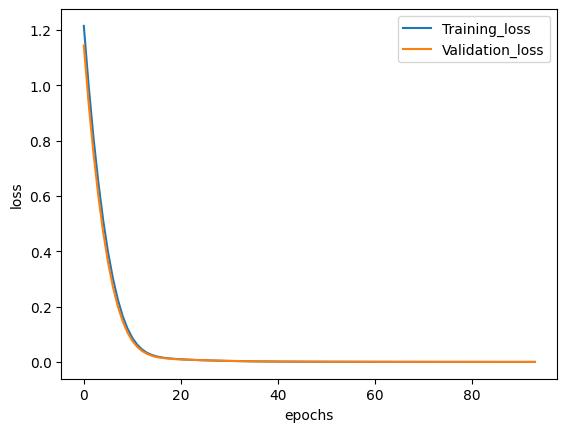

In [121]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Model check on Test data

In [122]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

1/1 [==============================] - 0s 298ms/step - loss: 2.1373e-05 - root_mean_squared_error: 0.0046


In [123]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f} rmse'.format(test_loss, test_accuracy))


Test loss: 0.0000. Test accuracy: 0.0046 rmse


In [124]:
prediction = model.predict(test_inputs)
data_inputs = pd.DataFrame(test_inputs)
prediction = pd.DataFrame(np.round(prediction,2))
test_targets = pd.DataFrame(test_targets)
pred_accu = np.round((prediction/test_targets)*100,2)

result = pd.concat([test_targets, prediction, pred_accu], axis = 1, ignore_index=True)
result.columns = ['Target-St(%)', 'Prediction-St(%)','Pred-Accu-St(%)']
result

1/1 [==============================] - 0s 122ms/step


,Target-St(%),Prediction-St(%),Pred-Accu-St(%)
0,0.94,0.94,100.00
1,0.95,0.95,100.00
2,0.94,0.94,100.00
3,0.95,0.95,100.00
4,0.98,0.97,98.98
5,0.99,0.99,100.00
6,0.98,0.98,100.00
7,0.98,0.98,100.00
8,0.97,0.97,100.00
9,0.99,0.98,98.99


Text(0.5, 0, 'Targets (red) & Predictions (blue)')

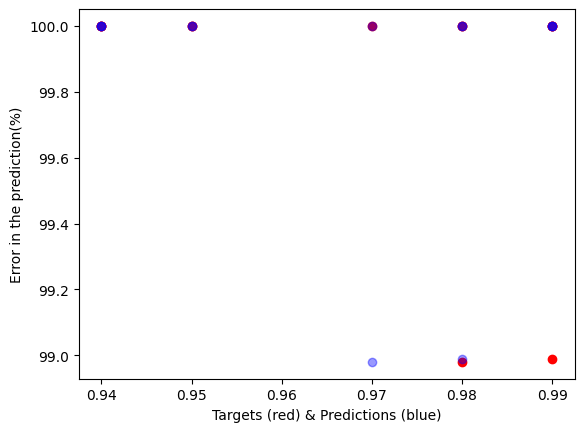

In [125]:
plt.scatter(result['Target-St(%)'], result['Pred-Accu-St(%)'], color='r')
plt.scatter(result['Prediction-St(%)'], result['Pred-Accu-St(%)'],alpha=0.4, color='b')
plt.ylabel('Error in the prediction(%)')
plt.xlabel('Targets (red) & Predictions (blue)')

Text(0.5, 0, 'Targets')

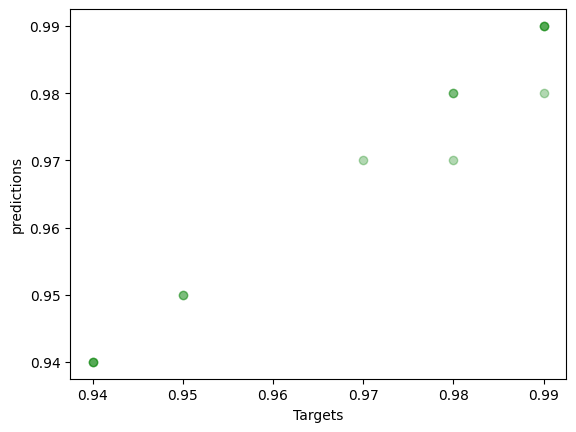

In [126]:
plt.scatter(result['Target-St(%)'], result['Prediction-St(%)'], alpha=0.3, color='g')
plt.ylabel('predictions')
plt.xlabel('Targets')

In [127]:
# estimation of R2 score
from sklearn.metrics import r2_score
r2_score_test = r2_score(test_targets, prediction)
r2_score_test

0.962750893950189

In [128]:
# estimation of adjusted R2 score
n = np.size(test_targets)
k = 3 # number of features
adj_r2_score = 1 - (((1-r2_score_test)*(n-1))/((n-k-1)))
adj_r2_score

0.9503345252669186

In [129]:
mean_pred = pred_accu.mean()
std_pred = pred_accu.std()
uncertainty_model = std_pred
print("Uncertainty of the ANN model:", np.round(uncertainty_model[0],2), '[%]')
print("Average test prediction precision", np.round(100 - uncertainty_model[0],2), '[%]')

Uncertainty of the ANN model: 0.38 [%]
Average test prediction precision 99.62 [%]


# ANN Model Deployment

ANN model deployment for micro DSC error prediction

In [130]:
import keras
model.save('micro_dsc_dl.h5')